# Numerical experiments III (variable selection)

### Notebook written by Matteo Sesia and Yaniv Romano
#### Stanford University, Department of Statistics
#### Last updated on: November 19, 2018

The purpose of this notebook is to allow the numerical experiments described in the paper to be reproduced easily.
Running this code may take several minutes.

## Load the required libraries

Additional dependencies for this notebook: 

- `glmnet_python` https://github.com/bbalasub1/glmnet_python

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
from DeepKnockoffs import KnockoffMachine
from DeepKnockoffs import GaussianKnockoffs
import data
import parameters
import selection
import sys

## Data generating model

We model $X \in \mathbb{R}^p $ as a multivariate Student's-t distribution, with $p=100$ and the covariance matrix of an auto-regressive process of order one. The default correlation parameter for this distribution is $\rho =0.5$ and the number of degrees of freedom $\nu = 3$.

In [2]:
# Number of features
p = 100

# Load the built-in multivariate Student's-t model and its default parameters
# The currently available built-in models are:
# - gaussian : Multivariate Gaussian distribution
# - gmm      : Gaussian mixture model
# - mstudent : Multivariate Student's-t distribution
# - sparse   : Multivariate sparse Gaussian distribution 
model = "mstudent"
distribution_params = parameters.GetDistributionParams(model, p)

# Initialize the data generator
DataSampler = data.DataSampler(distribution_params)

## Second-order knockoffs

After computing the empirical covariance matrix of $X$ in the training dataset, we can initialize a generator of second-order knockoffs. The solution of the SDP determines the pairwise correlations between the original variables and the knockoffs produced by this algorithm.

In [3]:
# Number of training examples
n = 10000

# Sample training data
X_train = DataSampler.sample(n)
print("Generated a training dataset of size: %d x %d." %(X_train.shape))

# Compute the empirical covariance matrix of the training data
SigmaHat = np.cov(X_train, rowvar=False)

# Initialize generator of second-order knockoffs
second_order = GaussianKnockoffs(SigmaHat, mu=np.mean(X_train,0), method="sdp")

# Measure pairwise second-order knockoff correlations 
corr_g = (np.diag(SigmaHat) - np.diag(second_order.Ds)) / np.diag(SigmaHat)

print('Average absolute pairwise correlation: %.3f.' %(np.mean(np.abs(corr_g))))

Generated a training dataset of size: 10000 x 100.
Average absolute pairwise correlation: 0.462.


## Deep knockoff machine

The default parameters of the machine are set below, as most appropriate for the specific built-in model considered.

In [4]:
# Load the default hyperparameters for this model
training_params = parameters.GetTrainingHyperParams(model)

# Set the parameters for training deep knockoffs
pars = dict()
# Number of epochs
pars['epochs'] = 100
# Number of iterations over the full data per epoch
pars['epoch_length'] = 100
# Data type, either "continuous" or "binary"
pars['family'] = "continuous"
# Dimensions of the data
pars['p'] = p
# Size of the test set
pars['test_size']  = 0
# Batch size
pars['batch_size'] = int(0.5*n)
# Learning rate
pars['lr'] = 0.01
# When to decrease learning rate (unused when equal to number of epochs)
pars['lr_milestones'] = [pars['epochs']]
# Width of the network (number of layers is fixed to 6)
pars['dim_h'] = int(10*p)
# Penalty for the MMD distance
pars['GAMMA'] = training_params['GAMMA']
# Penalty encouraging second-order knockoffs
pars['LAMBDA'] = training_params['LAMBDA']
# Decorrelation penalty hyperparameter
pars['DELTA'] = training_params['DELTA']
# Target pairwise correlations between variables and knockoffs
pars['target_corr'] = corr_g
# Kernel widths for the MMD measure (uniform weights)
pars['alphas'] = [1.,2.,4.,8.,16.,32.,64.,128.]

Let's load the trained machine stored in the `tmp/` subdirectory.

In [5]:
# Where the machine is stored
checkpoint_name = "tmp/" + model

# Initialize the machine
machine = KnockoffMachine(pars)

# Load the machine
machine.load(checkpoint_name)

=> loading checkpoint 'tmp/mstudent_checkpoint.pth.tar'
=> loaded checkpoint 'tmp/mstudent_checkpoint.pth.tar' (epoch 100)


## Controlled variable selection

The knockoff generator can be used to perform variable selection on new observations of $X$ and artificial labels $Y$ sampled from some known conditional model $P_{Y \mid X}$.  In order to reduce the runtime, the results are averaged over 100 replications of the experiment, instead of 1000 as in the paper.

In [6]:
# Number of non-zero coefficients in P(Y|X)
signal_n = 30

# Amplitude of the non-zero coefficients 
signal_amplitude_vec = [3, 5, 7, 10, 15, 20, 25]

# Compute the FDR as the average proportion of false discoveries over n_experiments
n_experiments = 100

# Target FDR level
nominal_fdr = 0.1

Load the default parameters for the experiments corresponding to the chosen model.

In [7]:
test_params = parameters.GetFDRTestParams(model)

In [8]:
# Initialize table of results
results = pd.DataFrame(columns=['Model','Experiment', 'Method', 'FDP', 'Power', \
                                'Amplitude', 'Signals', 'Alpha', 'FDR.nominal'])

# Run experiments
for amp_id in range(len(signal_amplitude_vec)):
    # Set the signal amplitude
    signal_amplitude = signal_amplitude_vec[amp_id]
    print("Running %d experiments with signal amplitude: %.2f" %(n_experiments,signal_amplitude))

    for exp_id in range(n_experiments):
        # Show progress
        sys.stdout.write('\r')
        sys.stdout.write("[%-25s] %d%%" % ('='*int((exp_id+1)/n_experiments*25), ((exp_id+1)/n_experiments)*100))
        sys.stdout.flush()

        # Sample X
        X = DataSampler.sample(test_params["n"], test=True)
        
        # Sample Y|X
        y,theta = selection.sample_Y(X, signal_n=signal_n, signal_a=signal_amplitude)
    
        # Generate deep knockoffs
        Xk_m = machine.generate(X)
        # Compute importance statistics
        W_m  = selection.lasso_stats(X,Xk_m,y,alpha=test_params["elasticnet_alpha"],scale=False)
        # Select important variables with the knockoff filter
        selected_m, FDP_m, POW_m = selection.select(W_m, theta, nominal_fdr=nominal_fdr)
        # Store results
        results = results.append({'Model':model,'Experiment':exp_id, 'Method':'deep', 
                                  'Power':POW_m, 'FDP':FDP_m, \
                                  'Amplitude':signal_amplitude, 'Signals':signal_n, \
                                  'Alpha':0.1, 'FDR.nominal':nominal_fdr}, ignore_index=True)
        
        # Generate second-order knockoffs
        Xk_g = second_order.generate(X)
        # Compute importance statistics
        W_g  = selection.lasso_stats(X,Xk_g,y,alpha=test_params["elasticnet_alpha"],scale=False)
        # Select important variables with the knockoff filter
        selected_g, FDP_g, POW_g = selection.select(W_g, theta, nominal_fdr=nominal_fdr)
        # Store results
        results = results.append({'Model':model,'Experiment':exp_id, 'Method':'second-order',
                                  'Power':POW_g, 'FDP':FDP_g, \
                                  'Amplitude':signal_amplitude, 'Signals':signal_n, \
                                  'Alpha':0.1, 'FDR.nominal':nominal_fdr}, ignore_index=True)
        
    sys.stdout.write('\n')

Running 100 experiments with signal amplitude: 3.00
[=========================] 100%
Running 100 experiments with signal amplitude: 5.00
[=========================] 100%
Running 100 experiments with signal amplitude: 7.00
[=========================] 100%
Running 100 experiments with signal amplitude: 10.00
[=========================] 100%
Running 100 experiments with signal amplitude: 15.00
[=========================] 100%
Running 100 experiments with signal amplitude: 20.00
[=========================] 100%
Running 100 experiments with signal amplitude: 25.00
[=========================] 100%


Compute average power and false discovery rate for each value of the signal amplitude.

In [9]:
# Summarize results
results.groupby(['Model', 'Method', 'Amplitude', 'Alpha', 'FDR.nominal']).describe(percentiles=[])

FDP                      \
                                                   count      mean       std   
Model    Method       Amplitude Alpha FDR.nominal                              
mstudent deep         3         0.1   0.1          100.0  0.001000  0.010000   
                      5         0.1   0.1          100.0  0.019886  0.063278   
                      7         0.1   0.1          100.0  0.043976  0.070643   
                      10        0.1   0.1          100.0  0.035979  0.047498   
                      15        0.1   0.1          100.0  0.063980  0.064313   
                      20        0.1   0.1          100.0  0.075911  0.063298   
                      25        0.1   0.1          100.0  0.063252  0.055795   
         second-order 3         0.1   0.1          100.0  0.055974  0.129829   
                      5         0.1   0.1          100.0  0.092130  0.124531   
                      7         0.1   0.1          100.0  0.121968  0.106872   
                      10        0.1   0.1          100.0  0.152130  0.101825   
                      15        0.1   0.1          100.0  0.166158  0.109259   
                      20        0.1   0.1          100.0  0.161099  0.092079   
                      25        0.1   0.1          100.0  0.167098  0.093473   

                                                                            \
                                                   min       50%       max   
Model    Method       Amplitude Alpha FDR.nominal                            
mstudent deep         3         0.1   0.1          0.0  0.000000  0.100000   
                      5         0.1   0.1          0.0  0.000000  0.346154   
                      7         0.1   0.1          0.0  0.000000  0.250000   
                      10        0.1   0.1          0.0  0.000000  0.214286   
                      15        0.1   0.1          0.0  0.050000  0.242424   
                      20        0.1   0.1          0.0  0.065591  0.268293   
                      25        0.1   0.1          0.0  0.062500  0.285714   
         second-order 3         0.1   0.1          0.0  0.000000  0.636364   
                      5         0.1   0.1          0.0  0.000000  0.400000   
                      7         0.1   0.1          0.0  0.125000  0.380952   
                      10        0.1   0.1          0.0  0.160645  0.420000   
                      15        0.1   0.1          0.0  0.158770  0.462963   
                      20        0.1   0.1          0.0  0.158770  0.454545   
                      25        0.1   0.1          0.0  0.151515  0.454545   

                                                   Power                      \
                                                   count      mean       std   
Model    Method       Amplitude Alpha FDR.nominal                              
mstudent deep         3         0.1   0.1          100.0  0.003000  0.030000   
                      5         0.1   0.1          100.0  0.065000  0.155943   
                      7         0.1   0.1          100.0  0.268000  0.257891   
                      10        0.1   0.1          100.0  0.472667  0.263678   
                      15        0.1   0.1          100.0  0.759667  0.176910   
                      20        0.1   0.1          100.0  0.876333  0.136437   
                      25        0.1   0.1          100.0  0.926000  0.105365   
         second-order 3         0.1   0.1          100.0  0.059667  0.129689   
                      5         0.1   0.1          100.0  0.235333  0.242500   
                      7         0.1   0.1          100.0  0.493667  0.257663   
                      10        0.1   0.1          100.0  0.749667  0.210312   
                      15        0.1   0.1          100.0  0.884333  0.146677   
                      20        0.1   0.1          100.0  0.920000  0.120418   
                      25        0.1   0.1          100.0  0.953000  0.086209   

    

Plot the average power for each method as a function of the signal amplitude.

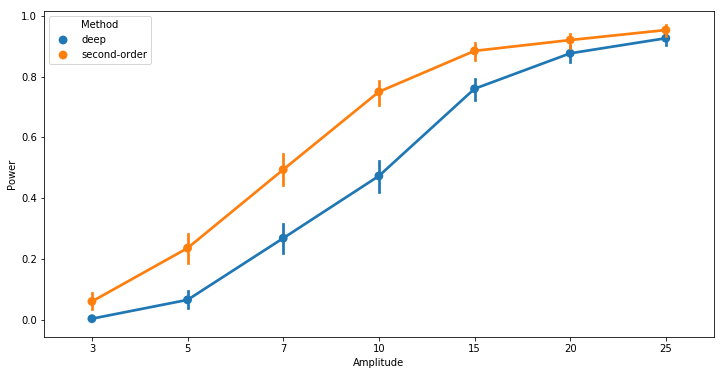

In [10]:
fig,ax = plt.subplots(figsize=(12,6))
sns.pointplot(x="Amplitude", y="Power", hue="Method", data=results)
fig

Plot the false discovery rate as a function of the signal amplitude.

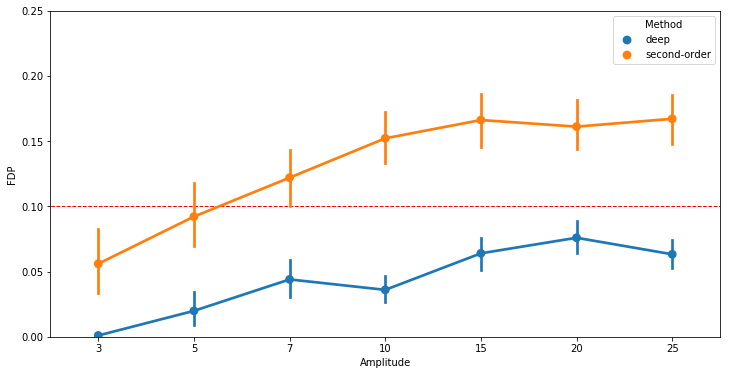

In [11]:
fig,ax = plt.subplots(figsize=(12,6))
plt.plot([-1, np.max(signal_amplitude_vec)+1], 
        [nominal_fdr, nominal_fdr], linewidth=1, linestyle="--", color="red")
sns.pointplot(x="Amplitude", y="FDP", hue="Method", data=results)
plt.ylim([0,0.25])
fig